In [ ]:
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
import os

path = '/content/gdrive/My Drive/Data-Centric_Competition/Data-Competition'
os.chdir(path)

In [ ]:
!pip install -U albumentations

In [ ]:
!pip install -r ./requirements.txt

# Library

In [ ]:
import pandas as pd
import numpy as np
import glob
import cv2
import os
import re

from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2, ToTensor

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt
import random

DIR_TRAIN = './dataset_origin/images/train'
DIR_VAL = './dataset_origin/images/val'
DIR_TEST = './dataset_origin/images/public_test'
DIR_KAGGLE = "./dataset_origin/data_kaggle/images/"


SEED = 42
def seed_everything(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    # tf.random.set_seed(seed)

seed_everything(SEED)

# Generate meta .csv files

In [ ]:
import glob
import pandas as pd
import numpy as np

def merge_per_folder(folder_path):
  """Read all txt annotation files & return a dataframe containing them
  Input:
    folder_path : folder's path contained txt files
  Output:
    Name of the output file the merged lines will be written to.
  """

  train_csv = list()
  # make sure there's a slash to the folder path 
  folder_path += "" if folder_path[-1] == "/" else "/"
  # get all text files
  txt_files = glob.glob(folder_path + "*.txt")

  # Read each txt file
  for txt_file in txt_files:
    id = [txt_file.strip().split('/')[-1][:-4], 960.0, 960.0]
    # Read the content of file
    with open(txt_file, 'rt') as fd:
      lines = fd.readlines()
      for line in lines:
        box = line.strip().split(' ')
        train_csv.append(id+box)
  
  return train_csv

# train_csv = merge_per_folder('./dataset_origin/labels/train')
# val_csv = merge_per_folder('./dataset_origin/labels/val')
# test_csv = merge_per_folder('./dataset_origin/labels/public_test')

In [ ]:
# df of Yolov5's bounding annotation
anno_train_csv = pd.DataFrame(train_csv, columns=['image_id', 'width', 'height', 'label', 'x', 'y', 'w', 'h'])
anno_train_csv[['width', 'height', 'label', 'x', 'y', 'w', 'h']] = anno_train_csv[['width', 'height', 'label', 'x', 'y', 'w', 'h']].astype(float)

# anno_train_csv.to_csv('./dataset_origin/train_csv.csv', index=False)

# Load train_csv data

In [ ]:
train_df = pd.read_csv('./dataset_origin/train_csv.csv', index_col=False)
val_df = pd.read_csv('./dataset_origin/val_csv.csv', index_col=False) 
test_df = pd.read_csv('./dataset_origin/test_csv.csv', index_col=False)

In [ ]:
print(f'There are totally {len(train_df["image_id"].unique())} images in total dataset')
print(f'There are totally {len(val_df["image_id"].unique())} images in val dataset')

There are totally 937 images in total dataset
There are totally 152 images in val dataset


In [ ]:
train_df

,image_id,width,height,label,x,y,w,h
0,1035,960.0,960.0,1.0,0.704688,0.522917,0.034375,0.098611
1,1035,960.0,960.0,1.0,0.551562,0.201389,0.045312,0.077778
2,289,960.0,960.0,1.0,0.241858,0.605691,0.059107,0.162602
3,504,960.0,960.0,1.0,0.296875,0.501389,0.064062,0.077778
4,504,960.0,960.0,2.0,0.791016,0.022917,0.021094,0.031944
...,...,...,...,...,...,...,...,...
1565,1047,960.0,960.0,1.0,0.454688,0.227083,0.040625,0.073611
1566,1047,960.0,960.0,0.0,0.734375,0.472222,0.053125,0.077778
1567,1047,960.0,960.0,1.0,0.402734,0.059028,0.032031,0.054167
1568,1047,960.0,960.0,1.0,0.848437,0.021528,0.020313,0.031944


## Filter images having people behide doors & in the dark

In [ ]:
# Some images ids needed to be augmented more to increase the accuracy
id_lst = [102, 20, 13, 27, 57, 66, 160, 192, 218, 217,219,408,674,801,632,923,222,428,560,545,874,881,229,509,531,575,584,576,870,871,885,
          157,158,396,397,393,885,854,214,848,421,622,918,919,118,330,4,111,119,511,520,586,333,336,161,394,541,544,547,878,611,613]
len(id_lst)

62

In [ ]:
behide_door_df = train_df.loc[[True if id in id_lst else False for id in train_df['image_id']]]
behide_door_df

,image_id,width,height,label,x,y,w,h
68,854,960.0,960.0,1.0,0.519141,0.511806,0.042969,0.112500
110,881,960.0,960.0,1.0,0.327734,0.184722,0.039844,0.088889
136,102,960.0,960.0,1.0,0.630078,0.349306,0.063281,0.118056
147,923,960.0,960.0,1.0,0.406250,0.135417,0.035937,0.073611
148,923,960.0,960.0,0.0,0.779297,0.115278,0.022656,0.036111
...,...,...,...,...,...,...,...,...
1542,870,960.0,960.0,1.0,0.481250,0.362500,0.060937,0.119444
1543,870,960.0,960.0,1.0,0.343359,0.168056,0.032031,0.066667
1558,509,960.0,960.0,1.0,0.755078,0.331944,0.046094,0.105556
1559,509,960.0,960.0,1.0,0.870703,0.431250,0.025781,0.087500


## Filter images having different type of masks

In [ ]:
id_lst = [12, 17, 225, 256, 39, 609, 659, 760, 797, 98, 160, 86, 634, 638, 639, 651, 650, 222, 223, 350, 661, 663, 678, 943, 518, 509, 531, 
          870, 871, 396, 313, 422, 626, 1037, 234, 323, 1038, 497, 586, 873, 621, 631, 644, 13, 662, 660, 1050, 1035]

len(id_lst)

48

In [ ]:
diff_mask_df = train_df.loc[[True if id in id_lst else False for id in train_df['image_id']]]
diff_mask_df

,image_id,width,height,label,x,y,w,h
0,1035,960.0,960.0,1.0,0.704688,0.522917,0.034375,0.098611
1,1035,960.0,960.0,1.0,0.551562,0.201389,0.045312,0.077778
111,659,960.0,960.0,1.0,0.629297,0.297917,0.049219,0.134722
112,659,960.0,960.0,1.0,0.791797,0.624306,0.061719,0.109722
141,17,960.0,960.0,1.0,0.424609,0.602083,0.069531,0.115278
...,...,...,...,...,...,...,...,...
1559,509,960.0,960.0,1.0,0.870703,0.431250,0.025781,0.087500
1560,509,960.0,960.0,1.0,0.633984,0.204167,0.019531,0.058333
1562,1050,960.0,960.0,0.0,0.484375,0.455556,0.043750,0.094444
1563,1050,960.0,960.0,1.0,0.536719,0.141667,0.017188,0.080556


In [ ]:
id_lst1 = [1035, 1029, 1041, 1034, 1027, 1002, 1049, 1050, 1048]
id_lst2 = [650, 465, 498, 630, 657, 466, 642]

final_df1 = val_df.loc[[True if id in id_lst1 else False for id in val_df['image_id']]]
final_df2 = val_df.loc[[True if id in id_lst2 else False for id in val_df['image_id']]]

final_df = pd.concat((final_df1, final_df2), axis=0).reset_index(drop=True)
final_df.head()

,image_id,width,height,label,x,y,w,h
0,1041,960.0,960.0,0.0,0.558984,0.373611,0.046094,0.077778
1,1050,960.0,960.0,0.0,0.484375,0.455556,0.043750,0.094444
2,1050,960.0,960.0,1.0,0.536719,0.141667,0.017188,0.080556
3,1050,960.0,960.0,1.0,0.558984,0.223611,0.016406,0.063889
4,1034,960.0,960.0,1.0,0.596484,0.295833,0.049219,0.094444


## Labels distribution of our data augmentation set

In [ ]:
import glob
import pandas as pd
import numpy as np

def merge_per_folder(folder_path):
  """Read all txt annotation files & return a dataframe containing them
  Input:
    folder_path : folder's path contained txt files
  Output:
    Name of the output file the merged lines will be written to.
  """

  train_csv = list()
  # make sure there's a slash to the folder path 
  folder_path += "" if folder_path[-1] == "/" else "/"
  # get all text files
  txt_files = glob.glob(folder_path + "*.txt")

  # Read each txt file
  for txt_file in txt_files:
    id = [txt_file.strip().split('/')[-1][:-4], 960.0, 960.0]
    # Read the content of file
    with open(txt_file, 'rt') as fd:
      lines = fd.readlines()
      for line in lines:
        box = line.strip().split(' ')
        train_csv.append(id+box)
  
  return train_csv

aug_df = merge_per_folder("./dataset_aug/labels/train")
aug_df = pd.DataFrame(aug_df, columns=['image_id', 'width', 'height', 'label', 'x', 'y', 'w', 'h'])
len(aug_df.image_id.unique())

2785

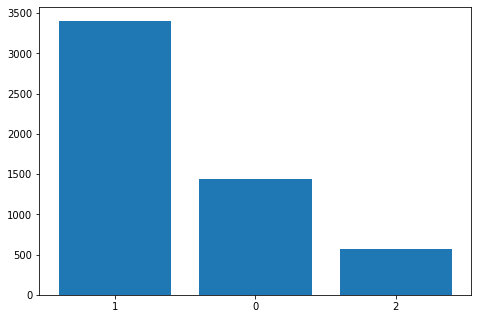

In [ ]:
import matplotlib.pyplot as plt

dis = aug_df['label'].value_counts()
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(list(dis.index), dis.values)
plt.show()

## Copy train, val & public_test images as well as annotation text files from "dataset" folder to "dataset_aug" folder (Already done don't run this part!!!!!)

In [ ]:
# DONE
def load_copy_images(start_folder, end_folder):
  """Load all the .jpeg images from the start_folder & save them into end_folder"""

  # make sure there's a slash to the folder path 
  start_folder += "" if start_folder[-1] == "/" else "/"
  # get all text files
  img_files = glob.glob(start_folder + "*.jpg")
  a = 0

  for img in img_files:
    # a += 1
    # if a > 200:
    #   break

    # Load the images from start_folder (dataset)
    img_arr = cv2.imread(img, cv2.IMREAD_COLOR)
    assert img_arr is not None, 'Image Not Found ' + img
    img_arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)  # BGR to RGB


    # Extract the name (id) of images
    img_id = img.strip().split('/')[-1][:-4]

    # Save images to end_folder (dataset_aug)
    im = Image.fromarray(img_arr, "RGB")
    im.save(f"{end_folder}/{img_id}.jpg")
    # print(f"{end_folder}/{img_id}.jpg")

# Public_test image folder
# load_copy_images('./dataset_origin/images/public_test', './dataset_origin/images/val')
# load_copy_images('./dataset_origin/data_kaggle/images', './dataset_aug/images/train')
# load_copy_images('./dataset_origin/images/train', './dataset_aug/images/train')

# Mosaic
# load_copy_images('./dataset_origin/data_aug/mosaic/images', './dataset_aug/images/train')

In [ ]:
# DONE
def load_copy_anno_txt(start_folder, end_folder):
  """Load & copy annotation txt files from start_folder (dataset) to end_folder (dataset_aug)"""
  # make sure there's a slash to the folder path 
  start_folder += "" if start_folder[-1] == "/" else "/"
  # get all text files
  txt_files = glob.glob(start_folder + "*.txt")
  a = 0

  for txt_f in txt_files:
    # Extract the name (id) of txt annotation file
    txt_id = txt_f.strip().split('/')[-1][:-4]

    with open(txt_f, 'r') as fd:
      lines = fd.readlines()
      # Save the string to txt file in end_folder (dataset_aug)
      txt_file = open(f'{end_folder}/{txt_id}.txt', 'w')
      for line in lines:
        txt_file.write(line)  # Write each txt line into a new file
      txt_file.close()
    # print(f'{end_folder}/{txt_id}.txt')

# public_test txt folder
# load_copy_anno_txt('./dataset_origin/labels/public_test', './dataset_origin/labels/val')
# load_copy_anno_txt('./dataset_origin/data_kaggle/labels', './dataset_aug/labels/train')
# load_copy_anno_txt('./dataset_origin/labels/train', './dataset_aug/labels/train')

# Mosaic
# load_copy_anno_txt('./dataset_origin/data_aug/mosaic/labels', './dataset_aug/labels/train')

### Filter labels of all images contained incorrect_mask labels from .csv metadata files

In [ ]:
def filterIncorrectMask(metadata_df):
  """
    Return metadata contained all image's id having incorrect_mask & other related label also
  """
  # Filter only label 2 "incorrect_mask"
  incorr = metadata_df.loc[metadata_df['label'] != 2]
  # Image's id contained label 2
  unique_id = incorr['image_id'].unique()
  # Filter all images contained incorrect_mask
  incorr_mask = metadata_df.loc[[True if id in unique_id else False for id in metadata_df['image_id']]]

  return incorr_mask.reset_index(drop=True)

# train_df = pd.read_csv('./dataset_origin/train_csv.csv', index_col=False)
# mask_no_mask = filterIncorrectMask(train_df)

# val_df = pd.read_csv('./dataset_origin/val_csv.csv', index_col=False)
# incorr_mask_val = filterIncorrectMask(val_df)

# test_df = pd.read_csv('./dataset_origin/test_csv.csv', index_col=False)
# incorr_mask_test = filterIncorrectMask(test_df)

In [ ]:
# DONE
def metadata_to_images(metadata_df, start_folder, end_folder):
  """Load the images based on metadata file"""
  # make sure there's a slash to the folder path 
  start_folder += "" if start_folder[-1] == "/" else "/"
  # Filter image id
  img_ids = metadata_df['image_id'].unique()

  # get all text files
  img_files = list()
  for id in img_ids:
    img_files.append(os.path.join(start_folder, str(id)+".jpg"))

  for img in img_files:
    # Load the images from start_folder (dataset)
    img_arr = cv2.imread(img, cv2.IMREAD_COLOR)
    assert img_arr is not None, 'Image Not Found '
    img_arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)  # BGR to RGB

    # Extract the name (id) of images
    img_id = img.strip().split('/')[-1][:-4]

    # Save images to end_folder (dataset_aug)
    im = Image.fromarray(img_arr, "RGB")
    im.save(f"{end_folder}/{img_id}.jpg")
    # print(f"{end_folder}/{img_id}.jpg")

In [ ]:
# DONE
def metadata_to_txt(metadata_df, start_folder, end_folder):
  """Load & copy annotation txt files from start_folder (dataset) to end_folder (dataset_aug)"""
  # make sure there's a slash to the folder path 
  start_folder += "" if start_folder[-1] == "/" else "/"

  # Filter image id
  txt_ids = metadata_df['image_id'].unique()

  # get all text files
  txt_files = list()
  for id in txt_ids:
    txt_files.append(os.path.join(start_folder, str(id)+".txt"))

  for txt_f in txt_files:
    # Extract the name (id) of txt annotation file
    txt_id = txt_f.strip().split('/')[-1][:-4]

    with open(txt_f, 'r') as fd:
      lines = fd.readlines()
      # Save the string to txt file in end_folder (dataset_aug)
      txt_file = open(f'{end_folder}/{txt_id}.txt', 'w')
      for line in lines:
        txt_file.write(line)  # Write each txt line into a new file
      txt_file.close()

In [ ]:
# metadata_to_images(incorr_val, './dataset_origin/images/val', './dataset_origin/images/train')
# metadata_to_txt(incorr_val, './dataset_origin/labels/val', './dataset_origin/labels/train')

# metadata_to_images(incorr_mask_df, './dataset_origin/images/train', './dataset_aug/images/train')
# metadata_to_txt(incorr_mask_df, './dataset_origin/labels/train', './dataset_aug/labels/train')

# metadata_to_images(incorr_mask_test, './dataset_origin/images/public_test', './dataset_origin/images/val')
# metadata_to_txt(incorr_mask_test, './dataset_origin/labels/public_test', './dataset_origin/labels/val')

In [ ]:
# DONE
def pattern_copy_images(start_folder, end_folder, pattern):
  """Load all the .jpeg images from the start_folder & save them into end_folder"""

  # make sure there's a slash to the folder path 
  start_folder += "" if start_folder[-1] == "/" else "/"
  # get all text files
  img_files = glob.glob(start_folder + "*.jpg")

  for img in img_files:
    # Load the images from start_folder (dataset)
    img_arr = cv2.imread(img, cv2.IMREAD_COLOR)
    assert img_arr is not None, 'Image Not Found ' + imgpath
    img_arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)  # BGR to RGB

    # Extract the name (id) of images
    img_id = img.strip().split('/')[-1][:-4]
    # Filter only image with pattern's name
    result = re.findall(pattern, img_id)

    if len(result):
      # Save images to end_folder (dataset_aug)
      im = Image.fromarray(img_arr, "RGB")
      print(im, f"{end_folder}/{result[0]}.jpg")
      im.save(f"{end_folder}/{result[0]}.jpg")


## Delete files based on list of id 

In [ ]:
# DELETE all the added images & annotation files from train_val folder
def delete_files_list(folder_path, indx_lst):
  """Delete all img_{}.jpeg or img_{}.txt files from a given folder base on the name's pattern"""
  a = 0
  # # (OPTION 1) DELETE IMAGE
  # # make sure there's a slash to the folder path 
  # folder_path += "" if folder_path[-1] == "/" else "/"
  # # get all text files
  # img_files = glob.glob(folder_path + "*.jpg")

  # for img_f in img_files:
  #   # Extract the name (id) of txt annotation file
  #   img_f = img_f.strip().split('/')[-1][:-4]

  #   if int(img_f) in indx_lst:
  #     # Remove file from folder
  #     os.remove(f"{folder_path}/{img_f}.jpg")
  #     # print(f"{folder_path}/{img_f}.jpg")


  # (OPTION 2) DELETE TXT FILE
  # make sure there's a slash to the folder path 
  folder_path += "" if folder_path[-1] == "/" else "/"
  # get all text files
  txt_files = glob.glob(folder_path + "*.txt")

  for txt_f in txt_files:
    # Extract the name (id) of txt annotation file
    txt_f = txt_f.strip().split('/')[-1][:-4]

    if int(txt_f) in indx_lst:
      a += 1
      # Remove file from folder
      os.remove(f"{folder_path}{txt_f}.txt")
      # print(f"{folder_path}{txt_f}.txt")

In [ ]:
# delete_files_list("./dataset_origin/images/val", incorr_lst)
# delete_files_list("./dataset_origin/labels/val", incorr_lst)

## Delete files based on pattern

In [ ]:
import glob
import re

def delete_files_base_pattern(folder_path, pattern):
  """Delete all img_{}.jpeg or img_{}.txt files from a given folder base on the name's pattern"""
  a = 0
  # # (OPTION 1) DELETE IMAGE
  # # make sure there's a slash to the folder path 
  # folder_path += "" if folder_path[-1] == "/" else "/"
  # # get all text files
  # img_files = glob.glob(folder_path + "*.jpg")

  # for img_f in img_files:
  #   # Extract the name (id) of txt annotation file
  #   img_f = img_f.strip().split('/')[-1][:-4]
  #   # Filter only image with name "img_{}.jpeg"
  #   result = re.findall(pattern, img_f)
  #   if len(result):
  #     # Remove file from folder
  #     os.remove(folder_path+result[0]+'.jpg')
  #     # print(folder_path+result[0]+'.jpg')


  # (OPTION 2) DELETE TXT FILE
  # make sure there's a slash to the folder path 
  folder_path += "" if folder_path[-1] == "/" else "/"
  # get all text files
  txt_files = glob.glob(folder_path + "*.txt")

  for txt_f in txt_files:
    # Extract the name (id) of txt annotation file
    txt_f = txt_f.strip().split('/')[-1][:-4]
    # Filter only image with pattern's name
    result = re.findall(pattern, txt_f)
    if len(result):
      a += 1
      # Remove file from folder
      os.remove(folder_path+result[0]+'.txt')
      # print(folder_path+result[0]+'.txt')

In [ ]:
# delete_files_base_pattern("./dataset_aug/images/train/", r"img_rotateShear_.*")
# delete_files_base_pattern("./dataset_aug/labels/train/", r"img_rotateShear_.*")

# delete_files_base_pattern("./dataset_aug/labels/train/", r"rsbbsc_.*")
# delete_files_base_pattern("./dataset_aug/images/train/", r"rsbbsc_.*")

# delete_files_base_pattern("./dataset_aug/images/train/", r"img_cutout_.*")
# delete_files_base_pattern("./dataset_aug/labels/train/", r"img_cutout_.*")

## Split up "train" and "val" dataset

In [ ]:
def split_images(start_folder, end_folder, file_ids):
  """Load all the .jpeg images from the start_folder & save them into end_folder"""
  # make sure there's a slash to the folder path 
  start_folder += "" if start_folder[-1] == "/" else "/"
  # get all text files
  img_files = glob.glob(start_folder + "*.jpg")

  for img in img_files:
    # Extract the name (id) of images
    img_id = img.strip().split('/')[-1][:-4]

    if int(img_id) in list(file_ids):
      # Load the images from start_folder (dataset)
      img_arr = cv2.imread(img, cv2.IMREAD_COLOR)
      assert img_arr is not None, 'Image Not Found ' + imgpath
      img_arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)  # BGR to RGB

      # Add images to end folder
      im = Image.fromarray(img_arr, "RGB")
      im.save(f"{end_folder}/{img_id}.jpg")
      # print(f"{end_folder}/{img_id}.jpg")
    else:
      continue

In [ ]:
# split_images('./dataset_origin/images/train_val', './dataset_origin/images/train', train_ids)
# split_images('./dataset_origin/images/train_val', './dataset_origin/images/val', val_ids)

In [ ]:
# DONE
def split_txt(start_folder, end_folder, file_ids):
  """Load & copy annotation txt files from start_folder (dataset) to end_folder (dataset_aug)"""
  # make sure there's a slash to the folder path 
  start_folder += "" if start_folder[-1] == "/" else "/"
  # get all text files
  txt_files = glob.glob(start_folder + "*.txt")
  for txt_f in txt_files:
    # Extract the name (id) of txt annotation file
    txt_id = int(txt_f.strip().split('/')[-1][:-4])

    if int(txt_id) in list(file_ids):
      with open(txt_f, 'r') as fd:
        lines = fd.readlines()
        # Save the string to txt file in end_folder (dataset_aug)
        txt_file = open(f'{end_folder}/{txt_id}.txt', 'w')
        for line in lines:
          txt_file.write(line)  # Write each txt line into a new file
        txt_file.close()


In [ ]:
# public_test txt folder
# split_txt('./dataset_origin/labels/train_val', './dataset_origin/labels/train', train_ids)
# split_txt('./dataset_origin/labels/train_val', './dataset_origin/labels/val', val_ids)

# FPT dataset creation
Great reference notebook: https://www.kaggle.com/sreevishnudamodaran/effdet-pytorch-cutmix-mixup-kfold-cosanneal

In [ ]:
from sklearn.utils import shuffle
import random
from torch.utils.data import DataLoader, Dataset

class FPTDataset(Dataset):
  def __init__(self, dataframe, image_dir, transforms=None):
    super().__init__()

    self.df = dataframe  # Annotation & Image's ID dataframe
    self.transforms = transforms  # Albumentation's augmentation
    self.image_ids = shuffle(dataframe['image_id'].unique())  # Image's ID
    self.labels = [np.zeros((0, 4), dtype=np.float32)] * len(self.image_ids) # Image's bboxes
    self.class_labels = [np.zeros((0, 1), dtype=np.float32)] * len(self.image_ids)  # Image's label
    self.image_dir = image_dir
    im_w = 1280
    im_h = 720

    # Loop through each image (Each image might containt multiple bboxes & labels)
    for i, img_id in enumerate(self.image_ids):
      records = self.df[self.df['image_id'] == img_id]
      boxes = records[['x', 'y', 'w', 'h']].values  # Annotations
      class_label = records[['label']].values
      self.labels[i] = np.array(boxes)
      self.class_labels[i] = class_label


  def __getitem__(self, index: int):
    # DATA AUGMENTATION
    if self.transforms is not None:
      # Load image
      image, (h0, w0) = load_image(self, index)

      # Augmentation
      augmented = self.transforms(image=image, bboxes=self.labels[index], class_labels=self.class_labels[index])
      image = augmented['image']
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # BGR to RGB
      bboxes = augmented['bboxes']
      labels = augmented['class_labels']
      return image, bboxes, labels

  def __len__(self) -> int:
    return self.image_ids.shape[0]


# Helper functions

In [ ]:
def load_image(self, index):
  # loads 1 image from dataset, returns img, original hw, resized hw
  """Load 1 image from dataset
  Input:
    index: idx to search for image's id
  Output:
    img, hw_original, hw_resized """
  # Read an image using opencv2
  image_id = self.image_ids[index]
  img = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
    
  assert img is not None, 'Image Not Found ' + imgpath
  h0, w0 = img.shape[:2]  # orig hw
  return img, (h0, w0)  # img, hw_original

def yolo_to_coco(self, bbox, orig_w, orig_h):
  bbox[:, 2] = bbox[:, 2]*orig_w
  bbox[:, 3] = bbox[:, 3]*orig_h
  bbox[:, 1] = bbox[:, 1]*orig_h - (bbox[:, 3]/2)
  bbox[:, 0] = bbox[:, 0]*orig_w - (bbox[:, 2]/2)
  return bbox

In [ ]:
def arr_to_str(arr, count_f):
  """Transform arr to string & save them to folder dataset_aug"""
  result = str()

  # Arr to String
  label_1 = int(arr[0])
  result = str(label_1) + ' '
  line = ' '.join([str(item) for item in arr[1:]]) + '\n'
  result = result + line
  return result


def pascal_to_yolo(xmin, ymin, xmax, ymax, image_width=640, image_height=640):
  x_coord = (xmin + xmax) / 2 / image_width
  y_coord = (ymin + ymax) / 2 / image_height
  shape_width = (xmax - xmin) / image_width
  shape_height = (ymax - ymin) / image_height
  return x_coord, y_coord, shape_width, shape_height


def yolo_to_pascal(x, y, w, h, width, height):
  xmax = int((x*width) + (w * width)/2.0)
  xmin = int((x*width) - (w * width)/2.0)
  ymax = int((y*height) + (h * height)/2.0)
  ymin = int((y*height) - (h * height)/2.0)
  return xmin, ymin, xmax, ymax

In [ ]:
import random, math


def collate_fn(batch):
    return tuple(zip(*batch))

def aug_visualize(train_val_df, train_val_dir, transform):
  train_dataset = FPTDataset(train_val_df, train_val_dir, transform)  # 792 images
  train_data_loader = DataLoader(
      train_dataset,
      batch_size=9,
      shuffle=True,
      num_workers=4,
      collate_fn=collate_fn
  )


  fig, ax = plt.subplots(3, 3, figsize=(25, 15))
  ax = ax.flatten()
  images, targets, class_labels = next(iter(train_data_loader))

  for i in range(9):  # Go through each batch 
    boxes = targets[i]
    sample = images[i]
    height, width = sample.shape[:2]

    for box in boxes:
      # Convert from Yolo to Pascal_voc
      box = yolo_to_pascal(box[0], box[1], box[2], box[3], width, height)
      # Drawing bounding box
      cv2.rectangle(sample,
                (int(box[0]), int(box[1])),
                (int(box[2]), int(box[3])),
                220, 3)

    ax[i].imshow(sample)  # Visualize a sample for each batch
  plt.show()

## Experiment 13 (Total < 3000 images)

In [ ]:
def RotateShear():
  return A.Compose([
      A.OneOf([
               A.augmentations.geometric.rotate.Rotate(limit=10, p=1.0),
               A.augmentations.geometric.transforms.Affine(shear=[-10,10], interpolation=1, p=1.0)
      ]),
      A.augmentations.transforms.HorizontalFlip(p=0.5),
      A.augmentations.geometric.resize.Resize(720, 1280, interpolation=1, always_apply=True, p=1.0),
  ], p=1.0, 
  # This "format" here is for coordinate of the input
  bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))


In [ ]:
# Visualize augmentation images
rotate_shear = RotateShear()
aug_visualize(diff_mask_df, DIR_TRAIN, rotate_shear)

# UNCOMMENT TO SAVE AUGMENTED IMAGES INTO FOLDER (.JPG + .TXT)
# train_dataset = FPTDataset(diff_mask_df, DIR_TRAIN, RotateShear())  # 792 images
# train_data_loader = DataLoader(
#     train_dataset,
#     batch_size=25,
#     shuffle=True,
#     num_workers=4,
#     collate_fn=collate_fn
# )

# a1 = 0
# b1 = 0

# # TRY GENERATE 50 AUGMENTED gray IMAGES & SAVE THEM TO "dataset_aug" FODLER 
# for i in range(2):
#   # Image & labels after data augmentation
#   imgs, targets, class_labels = next(iter(train_data_loader))

#   for bboxes, class_label in zip(targets, class_labels):
#     a1 += 1

#     txt_file = open(f'./dataset_aug/labels/train/img_rotateShear_diffmask_{a1}.txt', 'w')
#     # Through each bbox of an image
#     for j in range(len(bboxes)):
#       # Normalize the box's annotation after augmentation (AS requirement from competition)
#       a,b,c,d = bboxes[j][0], bboxes[j][1], bboxes[j][2], bboxes[j][3]
#       label_yolo = np.array([class_label[j][0], a, b, c, d])
#       label_yolo = arr_to_str(label_yolo, a1)

#       # Save the string for txt file
#       txt_file.write(label_yolo)
#     txt_file.close()
    

#   # Save images into folder "images/train"
#   for img in imgs:
#     b1 += 1
#     im = Image.fromarray(img, "RGB")
#     im.save(f'./dataset_aug/images/train/img_rotateShear_diffmask_{b1}.jpg')


In [ ]:
def heavyAugment():
  return A.Compose([
      A.OneOf([
               A.augmentations.transforms.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, 
                                                            val_shift_limit=0.2, p=0.9),
               A.augmentations.transforms.RandomBrightnessContrast (brightness_limit=0.2, contrast_limit=0.2, 
                                                                    brightness_by_max=True, always_apply=False, p=0.9),
      ]),
      A.OneOf([
               A.augmentations.transforms.GaussianBlur (blur_limit=(3, 5), sigma_limit=0, always_apply=False, p=0.7),
               A.augmentations.transforms.MotionBlur(blur_limit=(3, 5), p=0.7),
      ]),
      A.augmentations.transforms.CLAHE (clip_limit=(1, 2), tile_grid_size=(8, 8), always_apply=False, p=0.5),
      A.augmentations.geometric.resize.Resize(720, 1280, interpolation=1, always_apply=True, p=1.0),
  ], p=1.0, 
  # This "format" here is for coordinate of the input
  bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))


In [ ]:
heavy_aug = heavyAugment()
aug_visualize(train_val_df, DIR_TRAIN_VAL, heavy_aug)

# UNCOMMENT TO SAVE AUGMENTED IMAGES INTO FOLDER (.JPG + .TXT)
# train_dataset = FPTDataset(train_val_df, DIR_TRAIN_VAL, heavyAugment())  # 792 images
# train_data_loader = DataLoader(
#     train_dataset,
#     batch_size=25,
#     shuffle=True,
#     num_workers=4,
#     collate_fn=collate_fn
# )

# a1 = 0
# b1 = 0

# # TRY GENERATE 600 AUGMENTED gray IMAGES & SAVE THEM TO "dataset_aug" FODLER 
# for i in range(24):
#   # Image & labels after data augmentation
#   imgs, targets, class_labels = next(iter(train_data_loader))

#   for bboxes, class_label in zip(targets, class_labels):
#     a1 += 1

#     txt_file = open(f'./dataset_aug/labels/train/img_heavyAug_{a1}.txt', 'w')
#     # Through each bbox of an image
#     for j in range(len(bboxes)):
#       # Normalize the box's annotation after augmentation (AS requirement from competition)
#       a,b,c,d = bboxes[j][0], bboxes[j][1], bboxes[j][2], bboxes[j][3]
#       label_yolo = np.array([class_label[j][0], a, b, c, d])
#       label_yolo = arr_to_str(label_yolo, a1)

#       # Save the string for txt file
#       txt_file.write(label_yolo)
#     txt_file.close()
    

#   # Save images into folder "images/train"
#   for img in imgs:
#     b1 += 1
#     im = Image.fromarray(img, "RGB")
#     im.save(f'./dataset_aug/images/train/img_heavyAug_{b1}.jpg')


In [ ]:
def cutOut():
  return A.Compose([
      A.Cutout(num_holes=6, max_h_size=32, max_w_size=32, fill_value=0, p=1.0),
      A.augmentations.transforms.HorizontalFlip(p=0.8),
      A.augmentations.geometric.resize.Resize(720, 1280, interpolation=1, always_apply=False, p=1.0),
  ], p=1.0, 
  # This "format" here is for coordinate of the input
  bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))


In [ ]:
cutout = cutOut()
aug_visualize(final_df, DIR_VAL, cutout)

# UNCOMMENT TO SAVE AUGMENTED IMAGES INTO FOLDER (.JPG + .TXT)
# train_dataset = FPTDataset(final_df, DIR_VAL, cutOut())  # 792 images
# train_data_loader = DataLoader(
#       train_dataset,
#       batch_size=25,
#       shuffle=True,
#       num_workers=4,
#       collate_fn=collate_fn
# )

# a1 = 0
# b1 = 0

# # TRY GENERATE 50 AUGMENTED RANDOM TONE CURVE IMAGES & SAVE THEM TO "dataset_aug" FODLER 
# for i in range(2):
#   # Image & labels after data augmentation
#   imgs, targets, class_labels = next(iter(train_data_loader))

#   for bboxes, class_label in zip(targets, class_labels):
#     a1 += 1

#     txt_file = open(f'./dataset_aug/labels/train/img_cutout_final_{a1}.txt', 'w')
#     # Through each bbox of an image
#     for j in range(len(bboxes)):
#       # Normalize the box's annotation after augmentation (AS requirement from competition)
#       a,b,c,d = bboxes[j][0], bboxes[j][1], bboxes[j][2], bboxes[j][3]
#       label_yolo = np.array([class_label[j][0], a, b, c, d])
#       label_yolo = arr_to_str(label_yolo, a1)

#       # Save the string for txt file
#       txt_file.write(label_yolo)
#     txt_file.close()
    

#   # Save images into folder "images/train"
#   for img in imgs:
#     b1 += 1
#     im = Image.fromarray(img, "RGB")
#     im.save(f'./dataset_aug/images/train/img_cutout_final_{b1}.jpg')


/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:691: FutureWarning: This class has been deprecated. Please use CoarseDropout
  FutureWarning,


In [ ]:
def toGray():
  return A.Compose([
      A.augmentations.transforms.ToGray(p=1.0),
      # A.augmentations.transforms.HorizontalFlip(p=1.0),
      A.augmentations.geometric.resize.Resize(720, 1280, interpolation=1, always_apply=False, p=1.0),
  ], p=1.0, 
  # This "format" here is for coordinate of the input
  bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))


In [ ]:
togray = toGray()
aug_visualize(train_df, DIR_TRAIN, togray)

# UNCOMMENT TO SAVE AUGMENTED IMAGES INTO FOLDER (.JPG + .TXT)
# train_dataset = FPTDataset(train_df, DIR_TRAIN, toGray())  # 792 images
# train_data_loader = DataLoader(
#       train_dataset,
#       batch_size=25,
#       shuffle=True,
#       num_workers=4,
#       collate_fn=collate_fn
# )

# a1 = 0
# b1 = 0

# # TRY GENERATE 100 AUGMENTED horizontal flip IMAGES & SAVE THEM TO "dataset_aug" FODLER 
# for i in range(4):
#   # Image & labels after data augmentation
#   imgs, targets, class_labels = next(iter(train_data_loader))

#   for bboxes, class_label in zip(targets, class_labels):
#     a1 += 1

#     txt_file = open(f'./dataset_aug/labels/train/img_gray_{a1}.txt', 'w')
#     # Through each bbox of an image
#     for j in range(len(bboxes)):
#       # Normalize the box's annotation after augmentation (AS requirement from competition)
#       a,b,c,d = bboxes[j][0], bboxes[j][1], bboxes[j][2], bboxes[j][3]
#       label_yolo = np.array([class_label[j][0], a, b, c, d])
#       label_yolo = arr_to_str(label_yolo, a1)

#       # Save the string for txt file
#       txt_file.write(label_yolo)
#     txt_file.close()
    

#   # Save images into folder "images/train"
#   for img in imgs:
#     b1 += 1
#     im = Image.fromarray(img, "RGB")
#     im.save(f'./dataset_aug/images/train/img_gray_{b1}.jpg')

# print(a1, b1)

In [ ]:
def HorFlip():
  return A.Compose([
      A.augmentations.transforms.HorizontalFlip(p=0.7),
      A.augmentations.geometric.resize.Resize(720, 960, interpolation=1, always_apply=False, p=1.0),
  ], p=1.0, 
  # This "format" here is for coordinate of the input
  bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))


In [ ]:
# HORIZONTAL FLIP ONLY IMAGES CONTAINED INCORRECT_MASK LABEL
horFlip = HorFlip()
aug_visualize(need_aug_df, DIR_TRAIN, horFlip)

# UNCOMMENT TO SAVE AUGMENTED IMAGES INTO FOLDER (.JPG + .TXT)
# train_dataset = FPTDataset(need_aug_df, DIR_TRAIN, HorFlip())  # 792 images
# train_data_loader = DataLoader(
#       train_dataset,
#       batch_size=25,
#       shuffle=True,
#       num_workers=4,
#       collate_fn=collate_fn
# )

# a1 = 0
# b1 = 0

# # TRY GENERATE 100 AUGMENTED horizontal flip IMAGES & SAVE THEM TO "dataset_aug" FODLER 
# for i in range(4):
#   # Image & labels after data augmentation
#   imgs, targets, class_labels = next(iter(train_data_loader))

#   for bboxes, class_label in zip(targets, class_labels):
#     a1 += 1

#     txt_file = open(f'./dataset_aug/labels/train/img_hflip_needed_{a1}.txt', 'w')
#     # Through each bbox of an image
#     for j in range(len(bboxes)):
#       # Normalize the box's annotation after augmentation (AS requirement from competition)
#       a,b,c,d = bboxes[j][0], bboxes[j][1], bboxes[j][2], bboxes[j][3]
#       label_yolo = np.array([class_label[j][0], a, b, c, d])
#       label_yolo = arr_to_str(label_yolo, a1)

#       # Save the string for txt file
#       txt_file.write(label_yolo)
#     txt_file.close()
    

#   # Save images into folder "images/train"
#   for img in imgs:
#     b1 += 1
#     im = Image.fromarray(img, "RGB")
#     im.save(f'./dataset_aug/images/train/img_hflip_needed_{b1}.jpg')

In [ ]:
def hsvOrRandBrightContrast():
  return A.Compose([
      A.OneOf([
          A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, val_shift_limit=0.2, p=0.9),
          A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.9)], p=1.0),
      A.augmentations.geometric.resize.Resize(720, 1280, interpolation=1, always_apply=False, p=1.0),
  ], p=1.0, 
  # This "format" here is for coordinate of the input
  bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))


In [ ]:
# HSV or Random Brightness Contrast
horbc = hsvOrRandBrightContrast()
aug_visualize(train_df, DIR_TRAIN, horbc)

# UNCOMMENT TO SAVE AUGMENTED IMAGES INTO FOLDER (.JPG + .TXT)
# train_dataset = FPTDataset(train_df, DIR_TRAIN, hsvOrRandBrightContrast())  # 792 images
# train_data_loader = DataLoader(
#       train_dataset,
#       batch_size=25,
#       shuffle=True,
#       num_workers=4,
#       collate_fn=collate_fn
# )

# a1 = 0
# b1 = 0

# # TRY GENERATE 100 AUGMENTED horizontal flip IMAGES & SAVE THEM TO "dataset_aug" FODLER 
# for i in range(4):
#   # Image & labels after data augmentation
#   imgs, targets, class_labels = next(iter(train_data_loader))

#   for bboxes, class_label in zip(targets, class_labels):
#     a1 += 1

#     txt_file = open(f'./dataset_aug/labels/train/img_hsvOrBC_{a1}.txt', 'w')
#     # Through each bbox of an image
#     for j in range(len(bboxes)):
#       # Normalize the box's annotation after augmentation (AS requirement from competition)
#       a,b,c,d = bboxes[j][0], bboxes[j][1], bboxes[j][2], bboxes[j][3]
#       label_yolo = np.array([class_label[j][0], a, b, c, d])
#       label_yolo = arr_to_str(label_yolo, a1)

#       # Save the string for txt file
#       txt_file.write(label_yolo)
#     txt_file.close()
    

#   # Save images into folder "images/train"
#   for img in imgs:
#     b1 += 1
#     im = Image.fromarray(img, "RGB")
#     im.save(f'./dataset_aug/images/train/img_hsvOrBC_{b1}.jpg')

In [ ]:
def RandomSizedBBoxSafeCrop():
  return A.Compose([
      A.RandomSizedBBoxSafeCrop(720, 1280, erosion_rate=0, interpolation=cv2.INTER_AREA, p=1.0),
      # A.augmentations.geometric.resize.Resize(720, 1280, interpolation=1, always_apply=False, p=1.0),
  ], p=1.0, 
  # This "format" here is for coordinate of the input
  bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))


In [ ]:
rsbbsc = RandomSizedBBoxSafeCrop()
aug_visualize(train_df, DIR_TRAIN, rsbbsc)

# UNCOMMENT TO SAVE AUGMENTED IMAGES INTO FOLDER (.JPG + .TXT)
# train_dataset = FPTDataset(train_df, DIR_TRAIN, RandomSizedBBoxSafeCrop())
# train_data_loader = DataLoader(
#     train_dataset,
#     batch_size=25,
#     shuffle=True,
#     num_workers=4,
#     collate_fn=collate_fn
# )

# a1 = 0
# b1 = 0

# # TRY GENERATE 600 AUGMENTED sharpen IMAGES & SAVE THEM TO "dataset_aug" FODLER 
# for i in range(24):
#   # Image & labels after data augmentation
#   imgs, targets, class_labels = next(iter(train_data_loader))

#   for bboxes, class_label in zip(targets, class_labels):
#     a1 += 1

#     # txt_file = open(f'./dataset_aug/labels/train/rsbbsc_{a1}.txt', 'w')
#     txt_file = open(f'./dataset_origin/data_aug/randsafecrop/labels/rsbbsc_{a1}.txt', 'w')
#     # Through each bbox of an image
#     for j in range(len(bboxes)):
#       # Normalize the box's annotation after augmentation (AS requirement from competition)
#       a,b,c,d = bboxes[j][0], bboxes[j][1], bboxes[j][2], bboxes[j][3]
#       label_yolo = np.array([class_label[j][0], a, b, c, d])
#       label_yolo = arr_to_str(label_yolo, a1)

#       # Save the string for txt file
#       txt_file.write(label_yolo)
#     txt_file.close()
    

#   # Save images into folder "images/train"
#   for img in imgs:
#     b1 += 1
#     im = Image.fromarray(img, "RGB")
#     # im.save(f'./dataset_aug/images/train/rsbbsc_{b1}.jpg')
#     im.save(f'./dataset_origin/data_aug/randsafecrop/images/rsbbsc_{b1}.jpg')

## Mosaic

In [ ]:
from sklearn.utils import shuffle
import random

class FPTDatasetMosaic(Dataset):
  def __init__(self, dataframe, image_dir, transforms=None):
    super().__init__()

    self.df = dataframe  # Annotation & Image's ID dataframe
    self.image_ids = shuffle(dataframe['image_id'].unique())  # Image's ID
    self.labels = [np.zeros((0, 4), dtype=np.float32)] * len(self.image_ids) # Image's bboxes
    # self.class_labels = [np.zeros((0, 1), dtype=np.float32)] * len(self.image_ids)  # Image's label
    self.img_size = 960
    self.image_dir = image_dir
    self.mosaic = True
    im_w = 1280
    im_h = 720

    # Loop through each image (Each image might containt multiple bboxes & labels)
    for i, img_id in enumerate(self.image_ids):
      records = self.df[self.df['image_id'] == img_id]
      labels = records[['label', 'x', 'y', 'w', 'h']].values  # Annotations
      self.labels[i] = np.array(labels)

      
  def __getitem__(self, index: int):
    if self.mosaic == True:
      # Load mosaic
      img, labels = load_mosaic(self, index)
      shapes = None
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # BGR to RGB      
      return img, labels

  def __len__(self) -> int:
    return self.image_ids.shape[0]


In [ ]:
def random_affine(img, targets=(), degrees=10, translate=.1, scale=.1, shear=10, border=0):
    # torchvision.transforms.RandomAffine(degrees=(-10, 10), translate=(.1, .1), scale=(.9, 1.1), shear=(-10, 10))
    # https://medium.com/uruvideo/dataset-augmentation-with-random-homographies-a8f4b44830d4

    if targets is None:  # targets = [cls, xyxy]
        targets = []
    height = img.shape[0] + border * 2
    width = img.shape[1] + border * 2

    # Rotation and Scale
    R = np.eye(3)
    a = random.uniform(-degrees, degrees)
    # a += random.choice([-180, -90, 0, 90])  # add 90deg rotations to small rotations
    s = random.uniform(1 - scale, 1 + scale)
    R[:2] = cv2.getRotationMatrix2D(angle=a, center=(img.shape[1] / 2, img.shape[0] / 2), scale=s)

    # Translation
    T = np.eye(3)
    T[0, 2] = random.uniform(-translate, translate) * img.shape[0] + border  # x translation (pixels)
    T[1, 2] = random.uniform(-translate, translate) * img.shape[1] + border  # y translation (pixels)

    # Shear
    S = np.eye(3)
    S[0, 1] = math.tan(random.uniform(-shear, shear) * math.pi / 180)  # x shear (deg)
    S[1, 0] = math.tan(random.uniform(-shear, shear) * math.pi / 180)  # y shear (deg)

    # Combined rotation matrix
    M = S @ T @ R  # ORDER IS IMPORTANT HERE!!
    if (border != 0) or (M != np.eye(3)).any():  # image changed
        img = cv2.warpAffine(img, M[:2], dsize=(width, height), flags=cv2.INTER_LINEAR, borderValue=(114, 114, 114))

    # Transform label coordinates (Important!!!)
    n = len(targets)
    if n:
        # warp points
        xy = np.ones((n * 4, 3))
        xy[:, :2] = targets[:, [1, 2, 3, 4, 1, 4, 3, 2]].reshape(n * 4, 2)  # x1y1, x2y2, x1y2, x2y1
        xy = (xy @ M.T)[:, :2].reshape(n, 8)

        # create new boxes
        x = xy[:, [0, 2, 4, 6]]
        y = xy[:, [1, 3, 5, 7]]
        xy = np.concatenate((x.min(1), y.min(1), x.max(1), y.max(1))).reshape(4, n).T

        # # apply angle-based reduction of bounding boxes
        # radians = a * math.pi / 180
        # reduction = max(abs(math.sin(radians)), abs(math.cos(radians))) ** 0.5
        # x = (xy[:, 2] + xy[:, 0]) / 2
        # y = (xy[:, 3] + xy[:, 1]) / 2
        # w = (xy[:, 2] - xy[:, 0]) * reduction
        # h = (xy[:, 3] - xy[:, 1]) * reduction
        # xy = np.concatenate((x - w / 2, y - h / 2, x + w / 2, y + h / 2)).reshape(4, n).T

        # Explanation of this part of code: https://github.com/ultralytics/yolov5/issues/448
        # reject warped points outside of image
        xy[:, [0, 2]] = xy[:, [0, 2]].clip(0, width)
        xy[:, [1, 3]] = xy[:, [1, 3]].clip(0, height)
        w = xy[:, 2] - xy[:, 0]
        h = xy[:, 3] - xy[:, 1]
        area = w * h
        area0 = (targets[:, 3] - targets[:, 1]) * (targets[:, 4] - targets[:, 2])
        ar = np.maximum(w / (h + 1e-16), h / (w + 1e-16))  # aspect ratio
        i = (w > 4) & (h > 4) & (area / (area0 * s + 1e-16) > 0.2) & (ar < 10)

        targets = targets[i]
        targets[:, 1:5] = xy[i]

    return img, targets

In [ ]:
def load_mosaic(self, index):
    """Load image in a mosaic form _ combines 4 training images into one in certain ratios (instead of only two in CutMix"""

    labels4 = []
    s = self.img_size  # Size of image
    xc, yc = [int(random.uniform(s * 0.5, s * 1.5)) for _ in range(2)]  # mosaic center x, y
    indices = [index] + [random.randint(0, len(self.labels) - 1) for _ in range(3)]  # 3 additional image indices
    for i, index in enumerate(indices):
        # Load image
        img, (h, w) = load_image(self, index)

        # place img in img4
        if i == 0:  # top left
            img4 = np.full(shape=(s * 2, s * 2, img.shape[2]), fill_value=114, dtype=np.uint8)  # base image with 4 tiles
            x1a, y1a, x2a, y2a = max(xc - w, 0), max(yc - h, 0), xc, yc  # xmin, ymin, xmax, ymax (large image)
            x1b, y1b, x2b, y2b = w - (x2a - x1a), h - (y2a - y1a), w, h  # xmin, ymin, xmax, ymax (small image)
        elif i == 1:  # top right
            x1a, y1a, x2a, y2a = xc, max(yc - h, 0), min(xc + w, s * 2), yc
            x1b, y1b, x2b, y2b = 0, h - (y2a - y1a), min(w, x2a - x1a), h
        elif i == 2:  # bottom left
            x1a, y1a, x2a, y2a = max(xc - w, 0), yc, xc, min(s * 2, yc + h)
            x1b, y1b, x2b, y2b = w - (x2a - x1a), 0, max(xc, w), min(y2a - y1a, h)
        elif i == 3:  # bottom right
            x1a, y1a, x2a, y2a = xc, yc, min(xc + w, s * 2), min(s * 2, yc + h)
            x1b, y1b, x2b, y2b = 0, 0, min(w, x2a - x1a), min(y2a - y1a, h)

        img4[y1a:y2a, x1a:x2a] = img[y1b:y2b, x1b:x2b]  # img4[ymin:ymax, xmin:xmax]
        padw = x1a - x1b
        padh = y1a - y1b

        # Labels
        x = self.labels[index]
        labels = x.copy()
        if x.size > 0:  # Normalized xywh to pixel xyxy format
            labels[:, 1] = w * (x[:, 1] - x[:, 3] / 2) + padw
            labels[:, 2] = h * (x[:, 2] - x[:, 4] / 2) + padh
            labels[:, 3] = w * (x[:, 1] + x[:, 3] / 2) + padw
            labels[:, 4] = h * (x[:, 2] + x[:, 4] / 2) + padh
        labels4.append(labels)

    # Concat/clip labels
    if len(labels4):
        labels4 = np.concatenate(labels4, 0)
        # np.clip(labels4[:, 1:] - s / 2, 0, s, out=labels4[:, 1:])  # use with center crop
        np.clip(labels4[:, 1:], 0, 2 * s, out=labels4[:, 1:])  # use with random_affine

    # Reason should add "random_affine()" in mosaic https://github.com/ultralytics/yolov5/issues/448
    img4, labels4 = random_affine(img4, labels4,
                                  degrees=1.98 * 2,
                                  translate=0.05 * 2,
                                  scale=0.05 * 2,
                                  shear=0.641 * 2,
                                  border=-s // 2)  # border to remove

    return img4, labels4


In [ ]:
def arr_to_str(arr, count_f):
  """Transform arr to string & save them to folder dataset_aug"""
  result = str()

  # Arr to String
  label_1 = int(arr[0])
  result = str(label_1) + ' '
  line = ' '.join([str(item) for item in arr[1:]]) + '\n'
  result = result + line
  return result

def pascal_to_yolo(xmin, ymin, xmax, ymax, image_width=640, image_height=640):
  x_coord = (xmin + xmax) / 2 / image_width
  y_coord = (ymin + ymax) / 2 / image_height
  shape_width = (xmax - xmin) / image_width
  shape_height = (ymax - ymin) / image_height
  return x_coord, y_coord, shape_width, shape_height

def collate_fn(batch):
    return tuple(zip(*batch))

import random, math
import tensorflow as tf

def load_image(self, index):
  # loads 1 image from dataset, returns img, original hw, resized hw
  """Load 1 image from dataset
  Input:
    index: idx to search for image's id
  Output:
    img, hw_original, hw_resized """
  # Read an image using opencv2
  image_id = self.image_ids[index]
  img = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
    
  assert img is not None, 'Image Not Found ' + imgpath
  h0, w0 = img.shape[:2]  # orig hw
  return img, (h0, w0)  # img, hw_original

In [ ]:
train_dataset = FPTDatasetMosaic(train_df, DIR_TRAIN)  # 792 images
train_data_loader = DataLoader(
    train_dataset,
    batch_size=15,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn
)

def mosaic_filter(num_img):
  """
    Filter only mosaic image with number of labels larger than zero
    Input:
      num_img: # of wanted mosaic images
    Output:
      image_lst: list of mosaic images
      target_lst: list of appropriate mosaic labels
  """
  a = 0
  image_lst = list()
  target_lst = list()

  while (a < num_img):
    images, targets = next(iter(train_data_loader))
    for image, target in zip(images, targets):
      if len(target) > 1:
        image_lst.append(image)
        target_lst.append(target)
        a += 1
      else:
        continue

      if a == num_img:
        break

  return image_lst, target_lst

In [ ]:
# Construct 200 mosaic images
images, targets = mosaic_filter(144)

# Plot some filtered mosaic images
fig, ax = plt.subplots(6, 6, figsize=(40, 40))
ax = ax.flatten()

for i in range(36):  # Go through each batch 
    boxes = targets[i]
    sample = images[i]

    for box in boxes:
        cv2.rectangle(sample,
                  (int(box[1]), int(box[2])),
                  (int(box[3]), int(box[4])),
                  220, 3)

    ax[i].imshow(sample)  # Visualize a sample for each batch
plt.show()


In [ ]:
# UNCOMENT TO SAVE CREATED MOSAIC .JPG IMAGES & .TXT LABELS INTO FOLDER
# a1 = 0
# b1 = 0

# for img, label in zip(images, targets):
#   height, width = img.shape[:2]
#   a1 += 1

#   # txt_file = open(f'./dataset_aug/labels/train/img_mosaic_{a1}.txt', 'w')
#   txt_file = open(f'./dataset_origin/data_aug/mosaic/labels/img_mosaic_{a1}_a.txt', 'w')
#   # Through each bbox of an image
#   for j in range(len(label)):
#     # Normalize the box's annotation after augmentation (AS requirement from competition)
#     a,b,c,d = pascal_to_yolo(label[j][1], label[j][2], label[j][3], label[j][4], width, height)
#     label_yolo = np.array([label[j][0], a, b, c, d])
#     label_yolo = arr_to_str(label_yolo, a1)

#     # Save the string for txt file
#     txt_file.write(label_yolo)
#   txt_file.close()
    

# # Save images into folder "images/train"
# for img in images:
#   b1 += 1
#   im = Image.fromarray(img, "RGB")
#   # im.save(f'./dataset_aug/images/train/img_mosaic_b{b1}.jpg')
#   im.save(f'./dataset_origin/data_aug/mosaic/images/img_mosaic_{b1}_a.jpg')